<a href="https://www.kaggle.com/code/omerparlak/ab-test-for-bidding-methods?scriptVersionId=90502714" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Business Problem
One of our customers wants to change their advertising bidding method from "Maximum Bidding" to "Average Bidding".

Does this change make sense considering sales?

In [1]:
import numpy as np 
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 607 kB/s            


In [4]:
df_control = pd.read_excel("../input/ab-testing/ab_testing.xlsx", sheet_name = "Control Group")
df_test = pd.read_excel("../input/ab-testing/ab_testing.xlsx", sheet_name = "Test Group")

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################", end="\n\n")
    print(dataframe.shape, end="\n\n")
    print("##################### Types #####################", end="\n\n")
    print(dataframe.dtypes, end="\n\n")
    print("##################### Head #####################", end="\n\n")
    print(dataframe.head(head), end="\n\n")
    print("##################### Tail #####################", end="\n\n")
    print(dataframe.tail(head), end="\n\n")
    print("##################### NA #####################", end="\n\n")
    print(dataframe.isnull().sum(), end="\n\n")
    print("##################### Quantiles #####################", end="\n\n")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T, end="\n\n")
    print("##################### Describe #####################", end="\n\n")
    print(dataframe.describe().T, end="\n\n")

In [6]:
check_df(df_control)

##################### Shape #####################

(40, 4)

##################### Types #####################

Impression    float64
Click         float64
Purchase      float64
Earning       float64
dtype: object

##################### Head #####################

    Impression      Click  Purchase    Earning
0  82529.45927 6090.07732 665.21125 2311.27714
1  98050.45193 3382.86179 315.08489 1742.80686
2  82696.02355 4167.96575 458.08374 1797.82745
3 109914.40040 4910.88224 487.09077 1696.22918
4 108457.76263 5987.65581 441.03405 1543.72018

##################### Tail #####################

     Impression      Click  Purchase    Earning
35 132064.21900 3747.15754 551.07241 2256.97559
36  86409.94180 4608.25621 345.04603 1781.35769
37 123678.93423 3649.07379 476.16813 2187.72122
38 101997.49410 4736.35337 474.61354 2254.56383
39 121085.88122 4285.17861 590.40602 1289.30895

##################### NA #####################

Impression    0
Click         0
Purchase      0
Earning       0
dt

In [7]:
check_df(df_test)

##################### Shape #####################

(40, 4)

##################### Types #####################

Impression    float64
Click         float64
Purchase      float64
Earning       float64
dtype: object

##################### Head #####################

    Impression      Click  Purchase    Earning
0 120103.50380 3216.54796 702.16035 1939.61124
1 134775.94336 3635.08242 834.05429 2929.40582
2 107806.62079 3057.14356 422.93426 2526.24488
3 116445.27553 4650.47391 429.03353 2281.42857
4 145082.51684 5201.38772 749.86044 2781.69752

##################### Tail #####################

     Impression      Click  Purchase    Earning
35  79234.91193 6002.21358 382.04712 2277.86398
36 130702.23941 3626.32007 449.82459 2530.84133
37 116481.87337 4702.78247 472.45373 2597.91763
38  79033.83492 4495.42818 425.35910 2595.85788
39 102257.45409 4800.06832 521.31073 2967.51839

##################### NA #####################

Impression    0
Click         0
Purchase      0
Earning       0
dt

## Hypothesis of the AB Test

H0 is rejected if p-value < 0.05 

H0 cannot be rejected if p-value isn't < 0.05

H0: M1 = M2 - There is no statistically significant difference between the two groups In other words, it did not make a significant difference to our revenues between the use of maximum bidding and average bidding.

H1: M1 != M2 - There is a statistically significant difference between the two groups In other words, it has created a significant difference in our revenues between the use of maximum bidding and average bidding.



### Normality Assumption

The Shapiro-Wilks Test will be applied for the Normality

H0: The assumption of normal distribution is provided.

H1:..is not provided.

In [8]:
# For Control Group:
test_stat, pvalue = shapiro(df_control["Purchase"])
print('Test Stats for df_control = %.4f, p-value = %.4f' % (test_stat, pvalue))

# For Test Group:
test_stat, pvalue = shapiro(df_test["Purchase"])
print('Test Stats for df_test = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stats for df_control = 0.9773, p-value = 0.5891
Test Stats for df_test = 0.9589, p-value = 0.1541


For Control Group:

H0 cannot be rejected because the p-value = 0.5891 is greater than alpha = 0.05 

Normality assumption is provided.

For Test Group:

H0 cannot be rejected because the p-value = 0.1541 is greater than alpha = 0.05

Normality assumption is provided.


### Variance Homogeneity Assumption

Levene’s Test will be applied for the Homogeneity of variances

H0: Variances are homogeneous.

H1: Variances are not homogeneous.

In [9]:
test_stat, pvalue = levene(df_control["Purchase"],
                           df_test["Purchase"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 2.6393, p-value = 0.1083


H0 cannot be rejected because the p-value = 0.1083 is greater than alpha = 0.05

The assumption of homogeneity of variances was provided.

#### We can use parametric T-Test since both assumptions are provided.

In [10]:
test_stat, pvalue = ttest_ind(df_control["Purchase"],
                              df_test["Purchase"],
                              equal_var=True)

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = -0.9416, p-value = 0.3493


H0 cannot be rejected p-value = 0.3493 isn't < 0.05

H0: M1 = M2 - There is no statistically significant difference between the two groups In other words, it did not make a significant difference to our revenues between the use of maximum bidding and average bidding.

We can reevaluate by looking at more detailed statistics.

Purchase / Click ratio and Click / Impression ratio can be a good choice for comparison.

### Two Sample Ratio Test

H0: There is no statistically significant difference between the Sales Rate of the Control Group and the Sales Rate of the Test Group.

H1: There is statistically significant difference between the Sales Rate of the Control Group and the Sales Rate of the Test Group.

In [11]:
# Purchase/Click
test_stat, pvalue = proportions_ztest(count=[df_control["Purchase"].sum() , df_test["Purchase"].sum()],
                                      nobs=[df_control["Click"].sum(), df_test["Click"].sum()])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = -34.9800, p-value = 0.0000


H0 is rejected p-value = 0.0000 < alpha = 0.05

H1: There is statistically significant difference between the Sales Rate of the Control Group and the Sales Rate of the Test Group.

In [12]:
# Click / Impression
test_stat, pvalue = proportions_ztest(count=[df_control["Click"].sum(), df_test["Click"].sum()],
                                      nobs=[df_control["Impression"].sum(), df_test["Impression"].sum()])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 129.3305, p-value = 0.0000


H0 is rejected p-value = 0.0000 < alpha = 0.05

H1: There is statistically significant difference between the Sales Rate of the Control Group and the Sales Rate of the Test Group.

In [13]:
df_control["Purchase_ratio"] = df_control["Purchase"] / df_control["Click"]
df_control["Click_ratio"] = df_control["Click"] / df_control["Impression"]
df_control["control_or_test"]= "control"

df_test["Purchase_ratio"] = df_test["Purchase"] / df_test["Click"]
df_test["Click_ratio"] = df_test["Click"] / df_test["Impression"]
df_test["control_or_test"]= "test"

df_control_test = df_control.append(df_test)

In [14]:
df_control_test.reset_index(drop=True, inplace=True)

In [15]:
df_control_test

,Impression,Click,Purchase,Earning,Purchase_ratio,Click_ratio,control_or_test
0,82529.45927,6090.07732,665.21125,2311.27714,0.10923,0.07379,control
1,98050.45193,3382.86179,315.08489,1742.80686,0.09314,0.03450,control
2,82696.02355,4167.96575,458.08374,1797.82745,0.10991,0.05040,control
3,109914.40040,4910.88224,487.09077,1696.22918,0.09919,0.04468,control
4,108457.76263,5987.65581,441.03405,1543.72018,0.07366,0.05521,control
...,...,...,...,...,...,...,...
75,79234.91193,6002.21358,382.04712,2277.86398,0.06365,0.07575,test
76,130702.23941,3626.32007,449.82459,2530.84133,0.12404,0.02774,test
77,116481.87337,4702.78247,472.45373,2597.91763,0.10046,0.04037,test
78,79033.83492,4495.42818,425.35910,2595.85788,0.09462,0.05688,test


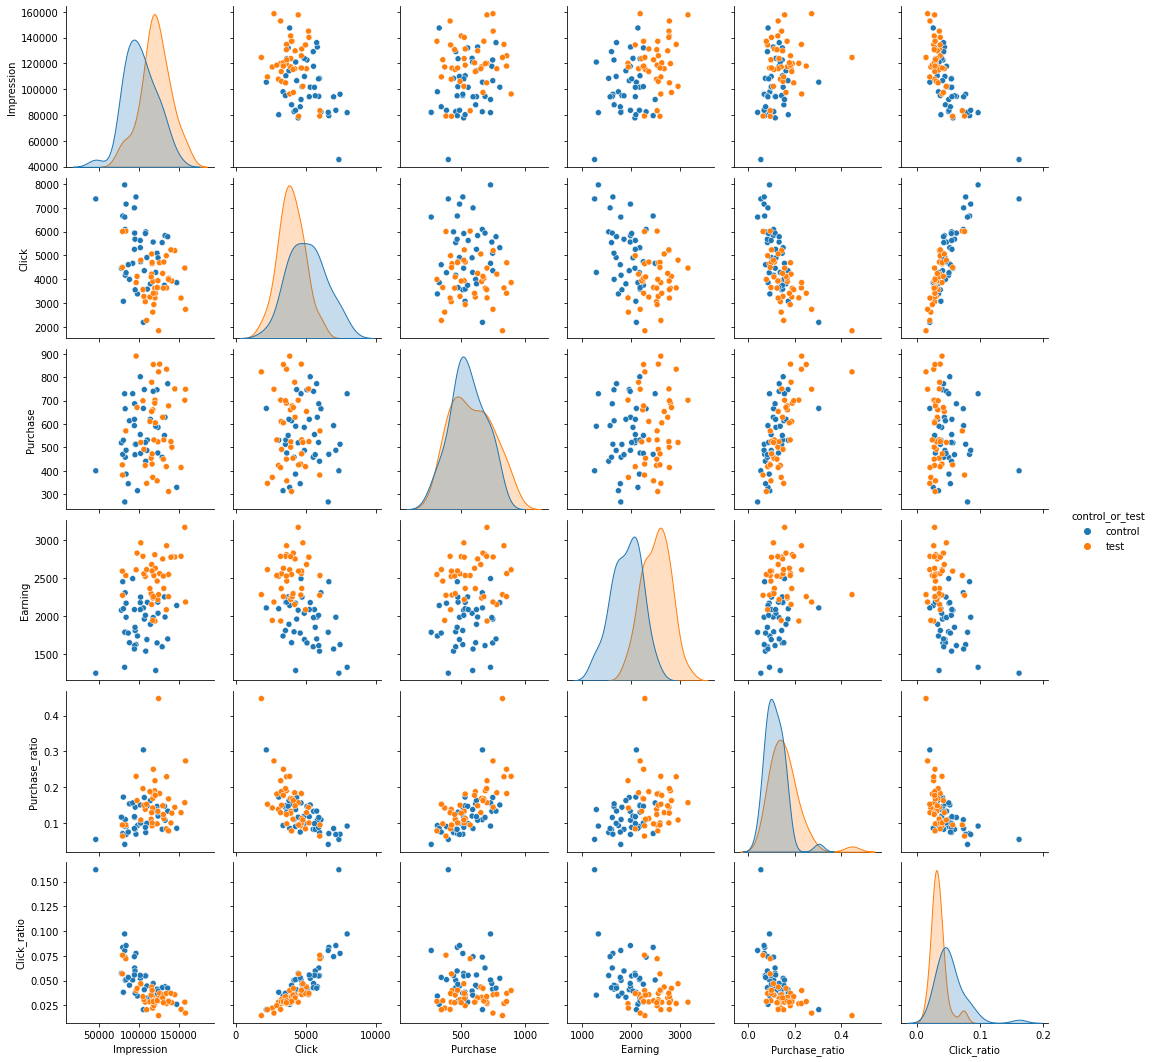

In [16]:
g = sns.pairplot(df_control_test, hue="control_or_test")

## Results
According to the rate tests we have done, there is a statistical difference between the maximum bidding and average bidding methods.
When we analyze our results graphically in order to understand better, we see that all our variables except for Purchase increased in the test group, while there was an increasing trend in Purchase_ratio.

It is predicted that the Purchase variable will increase as the Average Bidding continues to be tried.